#### Web scraping
##### May 8 2021
Extract gas prices from the web (https://bensinpriser.nu)
- [x] Extract text from homepage
- [x] Arrange text into table
- [ ] Save price for 
    - [x] Torvingegatan 1
    - [ ] mean for Linköping 
    - [ ] mean for Sthlm
- [x] Add todays price into a continous table, append?
- [x] Plot! (https://datascienceparichay.com/article/plot-a-line-chart-in-python-with-matplotlib/)
    - [ ] Make the plot sexier
- [x] Make a function that only adds a new line if the previous isnt from the same day (fool proof)
- [ ] Make a function that scraps every 24h
- [ ] Integrate script w/ github
    - [ ] Use actions, write yaml to run each 24h
    - [ ] Read: (https://octo.github.com/projects/flat-data)

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import date
import calendar

def fetch_data():
    url = 'https://bensinpriser.nu/stationer/95/ostergotlands-lan/linkoping/'
    i = 0
    while i < 10:
        if i==0:
            res = requests.get(url)
            print(url)
        if i>0:
            url1 = f"{url}{i}"
            res = requests.get(url1)
            print(url1)
       
        html_page = res.content

        soup = BeautifulSoup(html_page, 'html.parser')
        text = soup.find_all(text=True)

        # Remove various sections from the homepage
        output = ''
        blacklist = ['h2', 'tr', 'label', 'h4', 'ol', '[document]', 'a', 'h1', 
                     'noscript', 'span', 'header', 'ul', 'html', 'section', 
                     'article', 'em', 'meta', 'title', 'body', 'aside', 
                     'footer', 'div', 'form', 'nav', 'p', 'head', 'link', 
                     'strong', 'option','h6', 'br', 'li', 'h3', 'h5', 'script',
                    ]

        for t in text:
            if t.parent.name not in blacklist:
                output += '{} '.format(t)

        s = pd.DataFrame([x.split(';') for x in output.split('\n')])
        a = s[s.loc[:,0].str.contains('Torvingegatan')]
        
        if len(a)==0:
            i+=1
        if len(a)>0:
            return output

output = fetch_data()
#print(output)

https://bensinpriser.nu/stationer/95/ostergotlands-lan/linkoping/


In [2]:
import pandas as pd
from datetime import date
import calendar

s = pd.DataFrame([x.split(';') for x in output.split('\n')])
df = s[s.loc[:,0].str.contains('Torvingegatan')]
df = df.rename(columns={df.columns[0]:'col1'})
df[['col1', 'price', 'date']] = df.col1.str.rsplit(n=2, expand=True)
df[['station', 'city', 'address']] = df['col1'].str.split(n=2, expand=True)
df = df[['date', 'station', 'price', 'address', 'city']]

# Make price float
a = df.iloc[0].price.replace('kr', '')
a = float(a.replace(',', '.'))
df[['price']] = a

# Add date
today = date.today()

weekday = calendar.day_name[today.weekday()]
day = today.strftime("%d")
month = today.strftime("%B")
year = today.strftime("%Y")

df[['date']] = today
df[['yday']] = date.today().timetuple().tm_yday
df[['weekday']] = weekday
df[['day']] = day
df[['month']] = month
df[['year']] = year

df

,date,station,price,address,city,yday,weekday,day,month,year
20,2021-08-31,St1,16.54,Torvingegatan 1,Linköping,243.0,Tuesday,31,August,2021


In [3]:
# Check if the date already exist in the csv, not to add unnecessary rows
def update_table():
    d = pd.read_csv('data/bensinpris.csv', sep='\t')
    
    # If no previous file exists save with header
    #if ():
    #    df.to_csv('data/bensinpris.csv', sep='\t', header=True, mode='a', index=False)
    #    print('Table created')
    
    if (all(d.date != str(today))):
        print('Table updating...')
        df.to_csv('data/bensinpris.csv', sep='\t', header=False, mode='a', index=False)
    
    if any(d.date == str(today)):
        d1 = d.loc[d['date'] == str(today)]
        
        if (str(d1.price) == str(df.price)):
            print('Table already updated')
        
        if (str(d1.price) != str(df.price)):
            print('Table updating, replacing todays date')
            d = d[:-1] # Remove the last row, should be the latest date
            d = d.append(df, ignore_index=True)
            
            # Replace the previous csv
            d.to_csv('data/bensinpris.csv', sep='\t', header=True, mode='w', index=False)

update_table()

Table updating...


In [4]:
# Import the concatinated table
import pandas as pd
pris = pd.read_csv('data/bensinpris.csv', sep='\t')
pris.tail()

,date,station,price,address,city,yday,weekday,day,month,year
100,2021-08-26,St1,16.39,Torvingegatan 1,Linköping,238.0,Thursday,26,August,2021
101,2021-08-27,St1,16.39,Torvingegatan 1,Linköping,239.0,Friday,27,August,2021
102,2021-08-29,St1,16.39,Torvingegatan 1,Linköping,241.0,Sunday,29,August,2021
103,2021-08-30,St1,16.39,Torvingegatan 1,Linköping,242.0,Monday,30,August,2021
104,2021-08-31,St1,16.54,Torvingegatan 1,Linköping,243.0,Tuesday,31,August,2021


In [5]:
#pris.price.min()
#pris.yday.max()
#pris.yday.index("230")
rows = pris.index[pris['price'] < df.price.values[0]].tolist()
df1 = pris.iloc[rows,:]
#df1[df1['yday'] == df1.yday.max()]
#df.yday - df1.yday.max()
df['yday'].to_numpy() - df1.yday.max()

#df.index[df['points']==7].tolist()

array([1.])

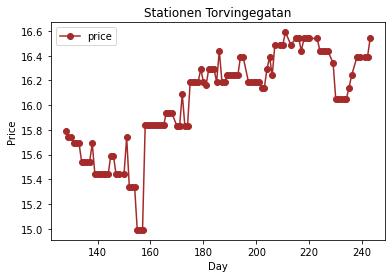

In [5]:
# Plot the price over time
import matplotlib.pyplot as plt

pris.plot(x='yday', y='price', color='brown', kind='line', marker='o')
plt.xlabel("Day")
plt.ylabel("Price")
plt.title("Stationen Torvingegatan")
plt.show()

<AxesSubplot:xlabel='weekday', ylabel='price'>

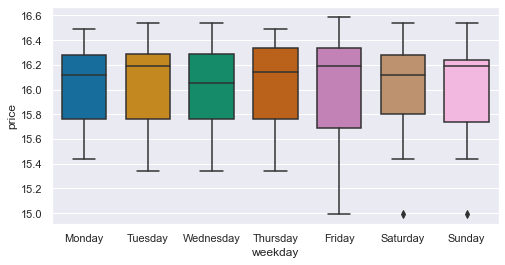

In [6]:
import seaborn as sns
sns.set(rc={"figure.figsize":(8, 4)}) #width=8, height=4
sns.boxplot(y='price', x='weekday', data=pris, width=0.7, palette="colorblind", 
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

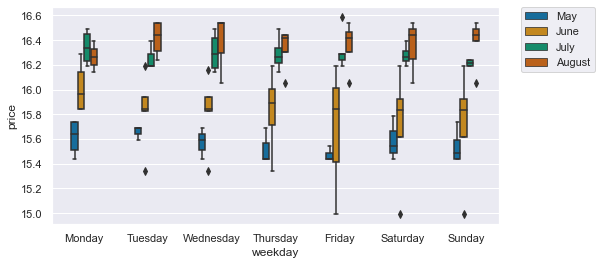

In [7]:
sns.boxplot(y='price', x='weekday', hue='month', data=pris, width=0.4, palette="colorblind", 
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

<AxesSubplot:xlabel='day', ylabel='price'>

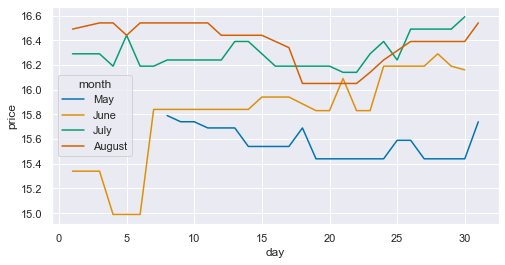

In [8]:
sns.lineplot(y='price', x='day', hue='month', data=pris, palette="colorblind")

<AxesSubplot:xlabel='day', ylabel='price'>

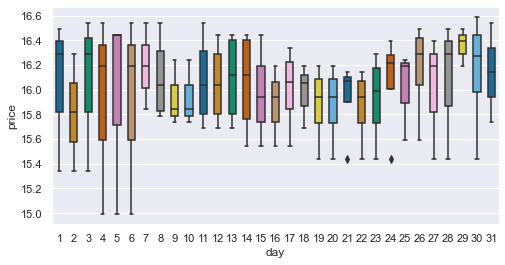

In [9]:
sns.boxplot(y='price', x='day', data=pris, width=0.5, palette="colorblind")

<AxesSubplot:xlabel='month', ylabel='price'>

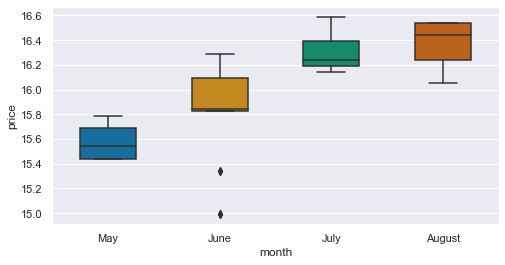

In [10]:
sns.boxplot(y='price', x='month', data=pris, width=0.5, palette="colorblind")